## Univariate Time Series with Prophet

### Importing time series

In [1]:
import pandas as pd
from prophet import Prophet

### Read CSV file

In [2]:
# Read UA csv data
df = pd.read_csv('ua_data.csv', thousands=',', quotechar='"', header=0)

### Data cleaning

In [3]:
# Convert the Date column to a datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [4]:
# Remove the 'TRY' prefix and commas, then convert the column to float
df['Revenue'] = df['Revenue'].str.replace('TRY', '').str.replace(',', '').astype(float)

In [5]:
# Show column types
print(df.dtypes)

Date                      datetime64[ns]
Revenue                          float64
Quantity                           int64
Unique Purchases                   int64
Quantity Added To Cart             int64
dtype: object


In [6]:
# Create a new DataFrame containing only the 'Quantity' and 'Date' columns
new_df = df[['Date', 'Quantity']]

In [7]:
# Rename the columns
new_df = new_df.rename(columns={'Date': 'ds', 'Quantity': 'y'})

In [8]:
# Check date values
df[df["Date"] == "2022-11-25"]

,Date,Revenue,Quantity,Unique Purchases,Quantity Added To Cart
409,2022-11-25,2470967.37,19539,17742,54158


### Prophet model implementation

In [9]:
# Initialize the Prophet model
m = Prophet()

# Fit the model to the data in new_df
m.fit(new_df)

13:38:39 - cmdstanpy - INFO - Chain [1] start processing
13:38:39 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# Create a DataFrame that extends into the future for 365 days
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
785,2023-12-06
786,2023-12-07
787,2023-12-08
788,2023-12-09
789,2023-12-10


In [11]:
# Generate forecasts for the dates in the 'future' DataFrame
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
785,2023-12-06,11717.668628,8909.696821,14648.098195
786,2023-12-07,11163.926005,8151.184767,14198.184277
787,2023-12-08,10485.172951,7547.391810,13298.732323
788,2023-12-09,9379.991438,6267.035291,12421.624032
789,2023-12-10,10499.859228,7484.685672,13396.627963


### Forecasting

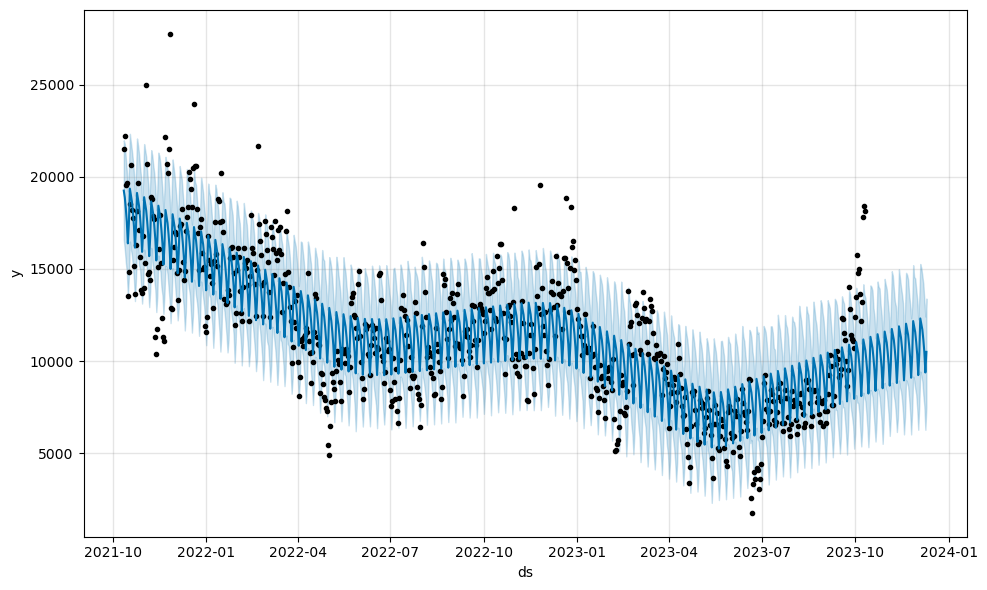

In [12]:
# Generate a plot to visualize the forecast data
fig1 = m.plot(forecast)

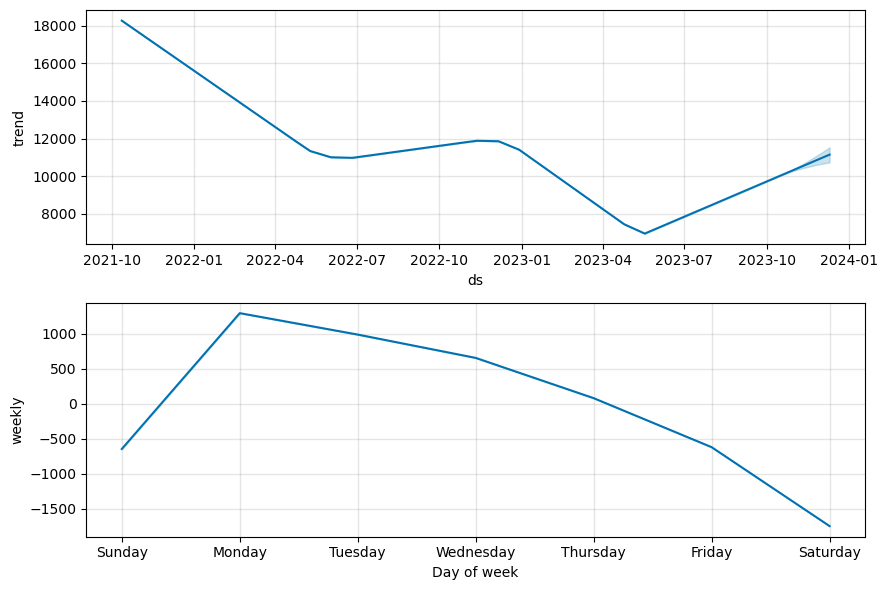

In [13]:
# Generate a plot to visualize the forecast data
fig2 = m.plot_components(forecast)

### Black Friday

In [14]:
# Filter the forecast DataFrame to find the row for November 24th
forecast_2023 = forecast[forecast['ds'] == '2023-11-24']
forecast_2023

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
773,2023-11-24,10819.642986,7215.587087,13110.54562,10588.48632,11046.015323,-619.732214,-619.732214,-619.732214,-619.732214,-619.732214,-619.732214,0.0,0.0,0.0,10199.910772


In [15]:
# Get columns
bf_2023 = forecast_2023[['ds', 'yhat']]

# Rename yhat column
bf_2023.rename(columns={'yhat': 'y'}, inplace=True)

/var/folders/71/lkmmy1vs5cs_qsl1fz5bhwqh0000gn/T/ipykernel_52479/488205451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bf_2023.rename(columns={'yhat': 'y'}, inplace=True)


In [17]:
new_df[new_df['ds'] == '2021-11-26']

,ds,y
45,2021-11-26,27764


In [18]:
bf_2021 = new_df[new_df['ds'] == '2021-11-26']
bf_2022 = new_df[new_df['ds'] == '2022-11-25']

In [19]:
black_friday = pd.concat([bf_2021, bf_2022, bf_2023], ignore_index=True)
black_friday

,ds,y
0,2021-11-26,27764.000000
1,2022-11-25,19539.000000
2,2023-11-24,10199.910772


In [20]:
# Change of quantities
black_friday['y_percent_change'] = black_friday['y'].pct_change() * 100
black_friday

,ds,y,y_percent_change
0,2021-11-26,27764.000000,NaN
1,2022-11-25,19539.000000,-29.624694
2,2023-11-24,10199.910772,-47.797171


In Black Friday, we anticipate a 47% decrease in the number of products sold compared to the previous year.

### Experiment

In [23]:
# Date ranges
start_date = '2021-10-12'
end_date = '2022-10-11'

date_range = pd.date_range(start=start_date, end=end_date)

# Sum of quantities
total_y = 0
for date in date_range:
    date_str = date.strftime('%Y-%m-%d')
    y_value = new_df[new_df['ds'] == date_str]['y'].values[0]
    total_y += y_value


total_y

4824994

In [22]:
# Date ranges
start_date = '2022-10-11'
end_date = '2023-10-11'

date_range = pd.date_range(start=start_date, end=end_date)

# Sum of quantities
total_y_y = 0
for date in date_range:
    date_str = date.strftime('%Y-%m-%d')
    y_value = new_df[new_df['ds'] == date_str]['y'].values[0]
    total_y_y += y_value


total_y_y

3473768

In [24]:
# Percentage changes by year
percent_change = ((total_y_y - total_y) / total_y) * 100
percent_change

-28.004718762344577

### Interactive figures

In [30]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [31]:
plot_components_plotly(m, forecast)